In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Assume ideal flow, non-Newtonian, non-compressible
# Viscosity estimated from "Influence of surfactant structure on polydisperse formulations of alkyl ether sulfates and alkyl amidopropyl betaines"
# Apply Hagen–Poiseuille equation

In [2]:
# Parameters
channel_size = 800e-6
viscosity = 0.2  # Pa.s
flow_rate = 40e-6 / 3600  # m^3/s
length = channel_size  # m
grid_points = 100 

In [3]:
# Define beta_n for the series terms
h = channel_size
l = channel_size
beta_n = lambda n: (2 * n - 1) * np.pi / h

In [4]:
n_terms = 50
def Q_function(G):
    term1 = (G * h**3 * l) / (12 * viscosity)
    term2 = 0
    for n in range(1, n_terms + 1):
        beta = beta_n(n)
        term2 += (1 / (2 * n - 1)**5) * ((np.cosh(beta * l) - 1) / np.sinh(beta * l))
    term2 *= (16 * G * h**4) / (np.pi**5 * viscosity)
    return term1 - term2 - flow_rate


In [5]:
# Solve G
G_initial_guess = 1e4 
pressure_gradient = fsolve(Q_function, G_initial_guess)[0]

In [6]:
x = np.linspace(0, h, grid_points)
z = np.linspace(0, l, grid_points)
X, Z = np.meshgrid(x, z)

In [7]:
velocity_profile = np.zeros_like(X)
for n in range(1, n_terms + 1):
    beta = beta_n(n)
    term = (np.sinh(beta * Z) + np.sinh(beta * (l - Z))) * np.sin(beta * X)
    term /= np.sinh(beta * l) * (2 * n - 1)**3
    velocity_profile += term

velocity_profile *= -4 * pressure_gradient * h**2 / (viscosity * np.pi**3)
velocity_profile += (pressure_gradient / (2 * viscosity)) * X * (h - X)

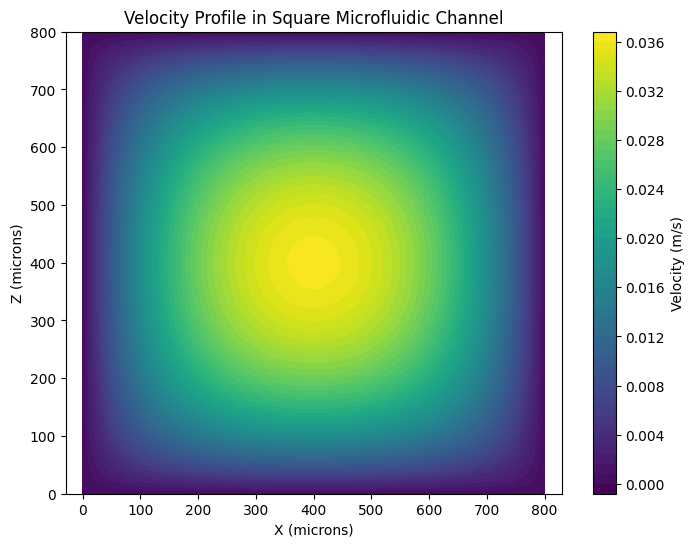

In [8]:
plt.figure(figsize=(8, 6))
plt.contourf(X * 1e6, Z * 1e6, velocity_profile, levels=50, cmap="viridis")
plt.colorbar(label="Velocity (m/s)")
plt.title("Velocity Profile in Square Microfluidic Channel")
plt.xlabel("X (microns)")
plt.ylabel("Z (microns)")
plt.axis("equal")
plt.show()

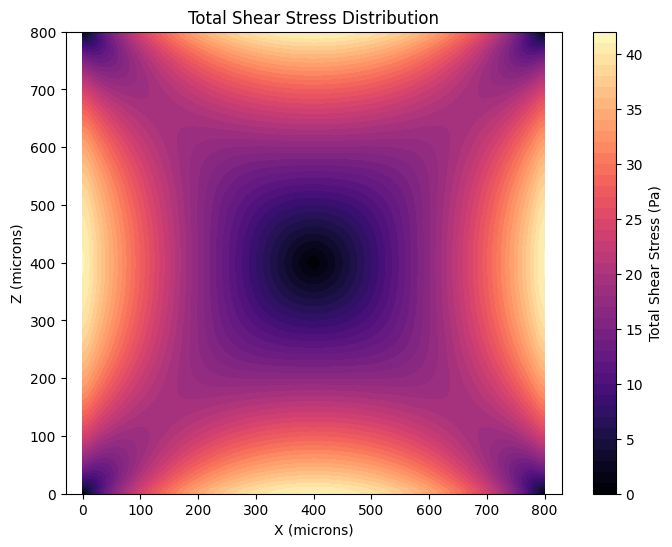

In [10]:
# Calculate shear stress
shear_stress_x = -viscosity * np.gradient(velocity_profile, axis=0) / (x[1] - x[0])  
shear_stress_z = -viscosity * np.gradient(velocity_profile, axis=1) / (z[1] - z[0])  
total_shear_stress = np.sqrt(shear_stress_x**2 + shear_stress_z**2)


plt.figure(figsize=(8, 6))
plt.contourf(X * 1e6, Z * 1e6, total_shear_stress, levels=50, cmap="magma")
plt.colorbar(label="Total Shear Stress (Pa)")
plt.title("Total Shear Stress Distribution")
plt.xlabel("X (microns)")
plt.ylabel("Z (microns)")
plt.axis("equal")
plt.show()
